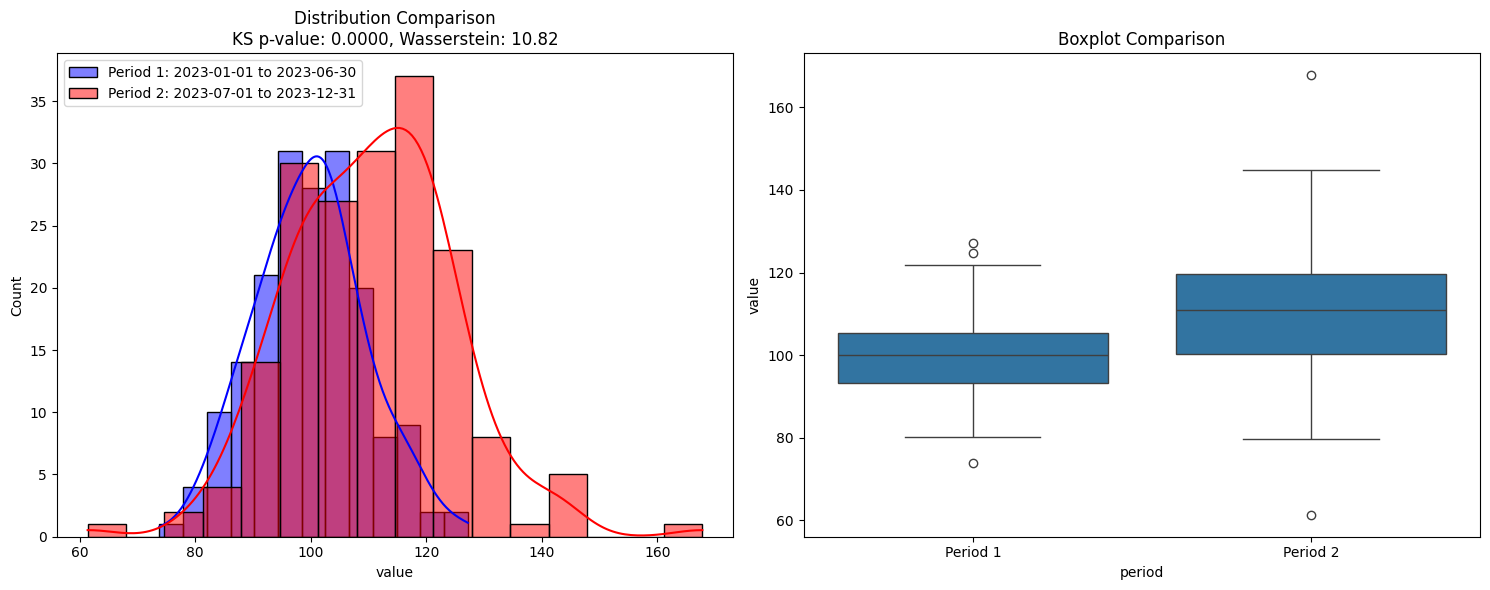


DRIFT ANALYSIS RESULTS:
Kolmogorov-Smirnov p-value: 0.0000
Significant drift detected: True
Wasserstein distance: 10.8233

Period 1 Statistics:
count    181.000000
mean      99.886910
std        9.586560
min       73.802549
25%       93.230780
50%      100.051135
75%      105.425600
max      127.201692
Name: value, dtype: float64

Period 2 Statistics:
count    184.000000
mean     110.569853
std       14.236875
min       61.380990
25%      100.219511
50%      111.005616
75%      119.574306
max      167.790972
Name: value, dtype: float64


In [1]:
# Question: Detecting Data Drift
# Description: Identify potential data drift between two time periods for a numeric attribute.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp, wasserstein_distance

def detect_data_drift(df, time_column, value_column, period1, period2, threshold=0.05):
    """
    Detect data drift for a numeric attribute between two time periods.
    
    Parameters:
    - df: DataFrame containing the data
    - time_column: Name of the column containing timestamps
    - value_column: Name of the numeric column to analyze
    - period1: Tuple of (start1, end1) for first period
    - period2: Tuple of (start2, end2) for second period
    - threshold: Significance level for statistical tests
    
    Returns:
    - Dictionary containing drift metrics and test results
    - Visualizations comparing distributions
    """
    
    # Convert to datetime if needed
    df[time_column] = pd.to_datetime(df[time_column])
    
    # Filter data for both periods
    period1_data = df[(df[time_column] >= period1[0]) & 
                      (df[time_column] <= period1[1])][value_column].dropna()
    period2_data = df[(df[time_column] >= period2[0]) & 
                      (df[time_column] <= period2[1])][value_column].dropna()
    
    # Basic statistics comparison
    stats1 = period1_data.describe(percentiles=[.25, .5, .75])
    stats2 = period2_data.describe(percentiles=[.25, .5, .75])
    
    # Statistical tests
    # Kolmogorov-Smirnov test for distribution similarity
    ks_stat, ks_pvalue = ks_2samp(period1_data, period2_data)
    
    # Wasserstein distance (Earth Mover's Distance)
    wasserstein_dist = wasserstein_distance(period1_data, period2_data)
    
    # Outlier analysis using Isolation Forest
    clf = IsolationForest(random_state=42)
    outliers1 = clf.fit_predict(period1_data.values.reshape(-1, 1))
    outliers2 = clf.fit_predict(period2_data.values.reshape(-1, 1))
    
    # Prepare results
    results = {
        'period1_stats': stats1,
        'period2_stats': stats2,
        'ks_test': {
            'statistic': ks_stat,
            'pvalue': ks_pvalue,
            'significant_drift': ks_pvalue < threshold
        },
        'wasserstein_distance': wasserstein_dist,
        'outlier_percentage': {
            'period1': (outliers1 == -1).mean(),
            'period2': (outliers2 == -1).mean()
        }
    }
    
    # Visualization
    plt.figure(figsize=(15, 6))
    
    # Histogram comparison
    plt.subplot(1, 2, 1)
    sns.histplot(period1_data, color='blue', alpha=0.5, label=f'Period 1: {period1[0]} to {period1[1]}', kde=True)
    sns.histplot(period2_data, color='red', alpha=0.5, label=f'Period 2: {period2[0]} to {period2[1]}', kde=True)
    plt.title(f'Distribution Comparison\nKS p-value: {ks_pvalue:.4f}, Wasserstein: {wasserstein_dist:.2f}')
    plt.xlabel(value_column)
    plt.legend()
    
    # Boxplot comparison
    plt.subplot(1, 2, 2)
    combined = pd.concat([
        pd.DataFrame({'value': period1_data, 'period': 'Period 1'}),
        pd.DataFrame({'value': period2_data, 'period': 'Period 2'})
    ])
    sns.boxplot(data=combined, x='period', y='value')
    plt.title('Boxplot Comparison')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Example Usage
if __name__ == "__main__":
    # Create sample time series data with drift
    np.random.seed(42)
    dates = pd.date_range('2023-01-01', '2023-12-31')
    values1 = np.random.normal(100, 10, 180)  # First 6 months
    values2 = np.random.normal(110, 15, 185)  # Last 6 months (with drift)
    
    df = pd.DataFrame({
        'date': dates,
        'value': np.concatenate([values1, values2])
    })
    
    # Define periods to compare (first 6 months vs last 6 months)
    period1 = ('2023-01-01', '2023-06-30')
    period2 = ('2023-07-01', '2023-12-31')
    
    # Detect drift
    drift_results = detect_data_drift(df, 'date', 'value', period1, period2)
    
    # Print results
    print("\nDRIFT ANALYSIS RESULTS:")
    print(f"Kolmogorov-Smirnov p-value: {drift_results['ks_test']['pvalue']:.4f}")
    print(f"Significant drift detected: {drift_results['ks_test']['significant_drift']}")
    print(f"Wasserstein distance: {drift_results['wasserstein_distance']:.4f}")
    print("\nPeriod 1 Statistics:")
    print(drift_results['period1_stats'])
    print("\nPeriod 2 Statistics:")
    print(drift_results['period2_stats'])
    